<h1>Cookies and Code: Advanved Stock Analysis with Python</h1>
<h3>By: Samuel Kellum</h3>

<h3>Web Scraping</h3>

If you look at quotes for various securities on Yahoo Finance, you might notice that the URL is always in the following format ```https://finance.yahoo.com/quote/{symbol}```. We can use this knowledge to quickly collect information for any security on Yahoo Finance.

The code below shows how you can concatenate a URL with Python code.

In [1]:
ticker = 'MSFT'
url = f'https://finance.yahoo.com/quote/{ticker}'
print(url)

https://finance.yahoo.com/quote/MSFT


In [2]:
ticker = 'TSLA'
url = f'https://finance.yahoo.com/quote/{ticker}'
print(url)

https://finance.yahoo.com/quote/TSLA


Now, to collect data from Yahoo Finance, we need to import a couple of libraries that give us access to various methods (or commands) that we want to use to collect the information from our desired URLs. (Note: you may need to uncomment (by removing ONLY the hashtag, not the percent sign) one or more the pip commands if an imported library is not installed on your machine.

In [3]:
#Import libraries
#%pip install requests
#%pip install bs4
import requests
from bs4 import BeautifulSoup

The first thing we need to do when using Python to collect data from a website is to perform a HTTP GET request on the URL.

To check whether or not the GET request was successful, we can return the status code of the get request.

If the HTTP response status code is 200-299, that means the GET request was successful.

More info on status codes: https://developer.mozilla.org/en-US/docs/Web/HTTP/Status#successful_responses

Some websites block requests that come in without a valid browser as a User-Agent, so we can pass in a user-agent as a parameter into the GET request.

In [4]:
#headers = {"User-Agent": "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/99.0.4844.51 Safari/537.36"}
r = requests.get(url)
print(r.status_code)

200


At this point, we will use Beautiful Soup to parse the data from a particular HTML element titled <i>"D(ib) Mend(20px)"</i> on Yahoo Finance, which will represent the stock price, change, and percent change:

In [5]:
soup = BeautifulSoup(r.text, 'html.parser')
data = soup.find('div', {'class': 'D(ib) Mend(20px)'}).find_all('fin-streamer')
data

[<fin-streamer active="" class="Fw(b) Fz(36px) Mb(-4px) D(ib)" data-field="regularMarketPrice" data-pricehint="2" data-symbol="TSLA" data-test="qsp-price" data-trend="none" value="985">985.00</fin-streamer>,
 <fin-streamer active="" class="Fw(500) Pstart(8px) Fz(24px)" data-field="regularMarketChange" data-pricehint="2" data-symbol="TSLA" data-test="qsp-price-change" data-trend="txt" value="-37.369995"><span class="C($negativeColor)">-37.37</span></fin-streamer>,
 <fin-streamer active="" class="Fw(500) Pstart(8px) Fz(24px)" data-field="regularMarketChangePercent" data-pricehint="2" data-symbol="TSLA" data-template="({fmt})" data-trend="txt" value="-0.03655232"><span class="C($negativeColor)">(-3.66%)</span></fin-streamer>,
 <fin-streamer active="true" changeev="regularTimeChange" class="D(n)" data-field="regularMarketTime" data-symbol="TSLA" data-trend="none" value=""></fin-streamer>,
 <fin-streamer active="true" changeev="marketState" class="D(n)" data-field="marketState" data-symbol=

At this point, the data looks pretty messy, but we can use ```.text``` to find the information between the `> <` symbols, which represents the information displayed on the website.

With a little bit of Python code, we can extract all of the information we are interested in.

In [6]:
print(ticker)
for i in range(len(data)):
    print(data[i].text)

TSLA
985.00
-37.37
(-3.66%)




Now, let's combine everything we learned above to create a function that can get the data for any security.

In [7]:
def getData(symbol):
    headers = {"User-Agent": "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/99.0.4844.51 Safari/537.36"}
    url = f'https://finance.yahoo.com/quote/{symbol}'

    r = requests.get(url, headers=headers)
    if 200 <= r.status_code < 300:
        soup = BeautifulSoup(r.text, 'html.parser')

        stock = {
            'symbol': symbol,
            'price' : soup.find('div', {'class': 'D(ib) Mend(20px)'}).find_all('fin-streamer')[0].text,
            'change' : soup.find('div', {'class': 'D(ib) Mend(20px)'}).find_all('fin-streamer')[1].text,
            'percent change': soup.find('div', {'class': 'D(ib) Mend(20px)'}).find_all('fin-streamer')[2].text
        }
        return stock
    else:
        return ("Error:", r.status_code)
        

This function works for any symbol that exists on yahoo finance, as shown below:

In [8]:
getData("MSFT")

{'symbol': 'MSFT',
 'price': '279.83',
 'change': '-7.79',
 'percent change': '(-2.71%)'}

In [9]:
getData("TSLA")

{'symbol': 'TSLA',
 'price': '985.00',
 'change': '-37.37',
 'percent change': '(-3.66%)'}

In [10]:
getData("BTC-USD")

{'symbol': 'BTC-USD',
 'price': '40,561.90',
 'change': '+608.98',
 'percent change': '(+1.52%)'}

<h3>Financial Analysis</h3>

Now, lets move onto the fun part, the financial analysis! Special thanks to the following YouTube video for providing some of the code that I will be using: https://www.youtube.com/watch?v=57qAxRV577c

<h4>Load Data</h4>

Import libraries:

In [11]:
#%pip install pandas
#%pip install pandas_datareader
#%pip install datetime
#%pip install matplotlib
#%pip install numpy
import pandas_datareader.data as web
import datetime
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
%matplotlib inline

To decide what date range we want to analyze, we can set the start and end dates with the `datetime` library.

In [12]:
start = datetime.datetime(2017,1,1) #Format: (YYYY, M, D)
end = datetime.date.today()
#Uncomment the line below and comment out the line above if you want to specify an earlier end date
#end = datetime.datetime(2022,1,1)

Now, we can pick which three (or more) stocks we want to compare!

The `web.DataReader` library will allow us to access the data in YahooFinance's API for any security within a date range we specify.

In [13]:
amzn = web.DataReader("AMZN", "yahoo", start, end)
tsla = web.DataReader("TSLA", "yahoo", start, end)
goog = web.DataReader("GOOG", "yahoo", start, end)

We can also speficy what hex code we want to represent the color for each security on our plots, this will help us later so we don't have to copy and paste the hex codes manually every time:

In [14]:
amzn_color = "#FF9900"
tsla_color = "#E82127"
goog_color = "#3CBA54"

We have now created three `DataFrames`, or tables, containing the daily trading information for each company, as shown below.

In [15]:
amzn

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2017-01-03,758.760010,747.700012,757.919983,753.669983,3521100,753.669983
2017-01-04,759.679993,754.200012,758.390015,757.179993,2510500,757.179993
2017-01-05,782.400024,760.260010,761.549988,780.450012,5830100,780.450012
2017-01-06,799.440002,778.479980,782.359985,795.989990,5986200,795.989990
2017-01-09,801.770020,791.770020,798.000000,796.919983,3446100,796.919983
...,...,...,...,...,...,...
2022-04-08,3147.370117,3084.620117,3135.000000,3089.209961,2295100,3089.209961
2022-04-11,3082.729980,3010.689941,3054.260010,3022.439941,2605600,3022.439941
2022-04-12,3101.979980,3007.659912,3073.850098,3015.750000,2758900,3015.750000


In [16]:
tsla

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2017-01-03,44.066002,42.192001,42.972000,43.397999,29616500.0,43.397999
2017-01-04,45.599998,42.862000,42.950001,45.397999,56067500.0,45.397999
2017-01-05,45.495998,44.389999,45.284000,45.349998,29558500.0,45.349998
2017-01-06,46.062000,45.090000,45.386002,45.801998,27639500.0,45.801998
2017-01-09,46.383999,45.599998,45.793999,46.256001,19897500.0,46.256001
...,...,...,...,...,...,...
2022-04-08,1048.439941,1022.440002,1043.209961,1025.489990,18293300.0,1025.489990
2022-04-11,1008.469971,974.640015,980.400024,975.929993,19785700.0,975.929993
2022-04-12,1021.190002,976.599976,997.640015,986.950012,21992000.0,986.950012


In [17]:
goog

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2017-01-03,789.630005,775.799988,778.809998,786.140015,1657300,786.140015
2017-01-04,791.340027,783.159973,788.359985,786.900024,1073000,786.900024
2017-01-05,794.479980,785.020020,786.080017,794.020020,1335200,794.020020
2017-01-06,807.900024,792.203979,795.260010,806.150024,1640200,806.150024
2017-01-09,809.966003,802.830017,806.400024,806.650024,1274600,806.650024
...,...,...,...,...,...,...
2022-04-08,2725.000000,2675.050049,2725.000000,2680.209961,821000,2680.209961
2022-04-11,2658.783936,2592.350098,2658.000000,2595.929932,1209400,2595.929932
2022-04-12,2648.469971,2551.520020,2648.469971,2567.489990,1150200,2567.489990


<h4>Price</h4>

Let's fist create a plot comparing the opening prices for each company, as shown below:

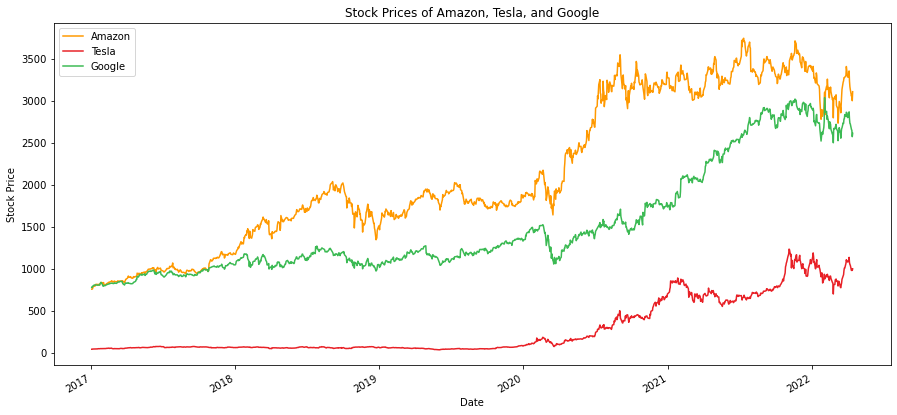

In [18]:
amzn["Open"].plot(label="Amazon", color=amzn_color, figsize=(15,7))
tsla["Open"].plot(label="Tesla", color=tsla_color)
goog["Open"].plot(label="Google", color=goog_color)
plt.legend()
plt.title("Stock Prices of Amazon, Tesla, and Google")
plt.ylabel("Stock Price")
plt.show()

<h4>Cumulative Return</h4>

Since it is difficult to compare securities with different stock prices, for each security, let's calculate the daily cumulative return:

In [19]:
first_day = amzn["Open"].iloc[0]
amzn["Cumulative Return"] = amzn["Open"] / first_day
first_day = tsla["Open"].iloc[0]
tsla["Cumulative Return"] = tsla["Open"] / first_day
first_day = goog["Open"].iloc[0]
goog["Cumulative Return"] = goog["Open"] / first_day

Let's create a plot comparing the cumulative return for each comapny.

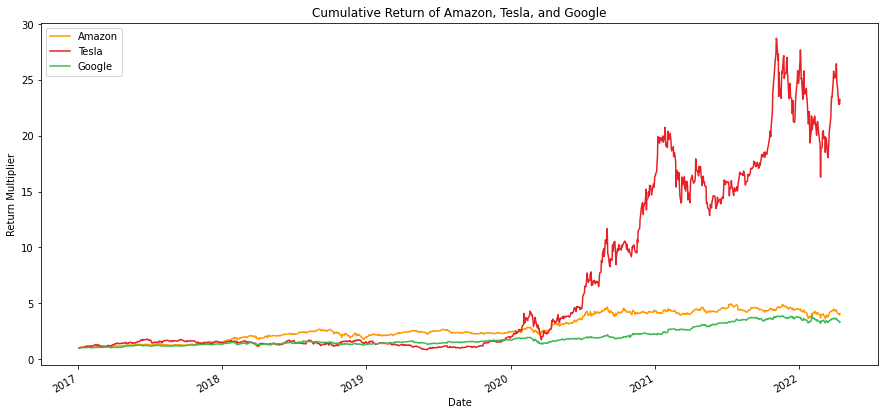

In [20]:
amzn["Cumulative Return"].plot(label="Amazon", color=amzn_color, figsize=(15,7))
tsla["Cumulative Return"].plot(label="Tesla", color=tsla_color)
goog["Cumulative Return"].plot(label="Google", color=goog_color)
plt.legend()
plt.title("Cumulative Return of Amazon, Tesla, and Google")
plt.ylabel("Return Multiplier")
plt.show()

From the plot above, we can tell that Tesla has grown the most by far since the beginning of 2017.

<h4>Volume</h4>

In addition to price and cumulative return, volume is an important metric to consider since it is generally a sign of movement.

Let's plot a visulaization of the volume for each company:

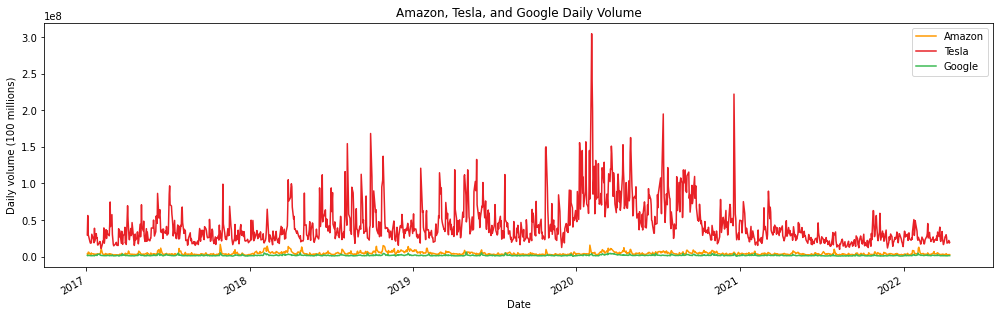

In [21]:
amzn["Volume"].plot(label="Amazon", color=amzn_color, figsize=(17,5))
tsla["Volume"].plot(label="Tesla", color=tsla_color)
goog["Volume"].plot(label="Google", color=goog_color)
plt.legend()
plt.title("Amazon, Tesla, and Google Daily Volume")
plt.ylabel("Daily volume (100 millions)")
plt.show()

These red spikes are interesting, let's check a couple of them out!

In [22]:
#Find row with highest volume
print(tsla["Volume"].argmax())
tsla.iloc[[tsla["Volume"].argmax()]]

776


,High,Low,Open,Close,Volume,Adj Close,Cumulative Return
Date,,,,,,,
2020-02-04,193.798004,166.776001,176.591995,177.412003,304694000.0,177.412003,4.109467


What happened around this time period? Let's do some investigation!

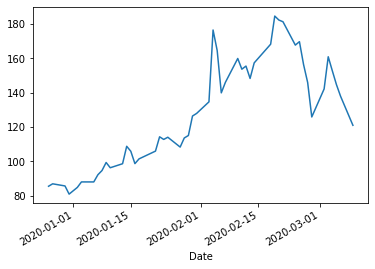

In [23]:
tsla.iloc[750:800]["Open"].plot()
plt.show()

Here is an article from the date of the maximum daily volume for Tesla: https://www.cnbc.com/2020/02/04/tesla-stock-surging-yet-again-tsla-jumps-past-800-in-early-trading.html

Volume does not take into account price, so let's compare the total dollar amount traded for each company:

In [24]:
amzn["Dollar Volume"] = amzn["Open"] * amzn["Volume"]
tsla["Dollar Volume"] = tsla["Open"] * tsla["Volume"]
goog["Dollar Volume"] = goog["Open"] * goog["Volume"]

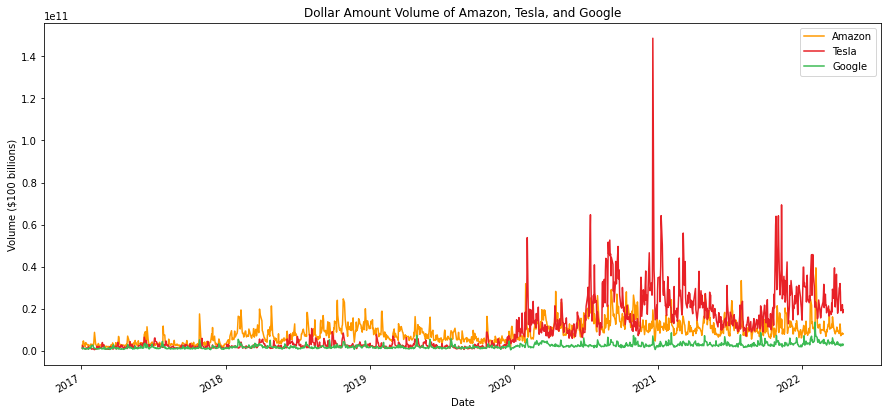

In [25]:
amzn["Dollar Volume"].plot(label="Amazon", color=amzn_color,  figsize=(15,7))
tsla["Dollar Volume"].plot(label="Tesla", color=tsla_color)
goog["Dollar Volume"].plot(label="Google", color=goog_color)
plt.legend()
plt.title("Dollar Amount Volume of Amazon, Tesla, and Google")
plt.ylabel("Volume ($100 billions)")
plt.show()

Holy cow! When we factor in share price, we found a new largest daily volume of $14 billion in one day! Let's investgate:

In [26]:
#Find row with highest volume
tsla.iloc[[tsla["Dollar Volume"].argmax()]]

,High,Low,Open,Close,Volume,Adj Close,Cumulative Return,Dollar Volume
Date,,,,,,,,
2020-12-18,695.0,628.539978,668.900024,695.0,222126200.0,695.0,15.56595,1.485802e+11


What happened on that day?
https://www.cnbc.com/2020/12/18/tesla-jumps-6percent-in-heavy-volume-sees-wild-trading-volume-more-than-130-billion-worth-of-stock-changes-hands-ahead-of-sp-add.html

<h4>Moving Average</h4>

When analyzing a security for long term investment, you might be skeptial of its true value based on what is seemingly noisy data, or random price fluctuations, meaningless in the long term.

Therefore, we can smooth the sharp edges with a moving average, which represents the average of a previous fixed time period. 

Let's check out Google's moving average:

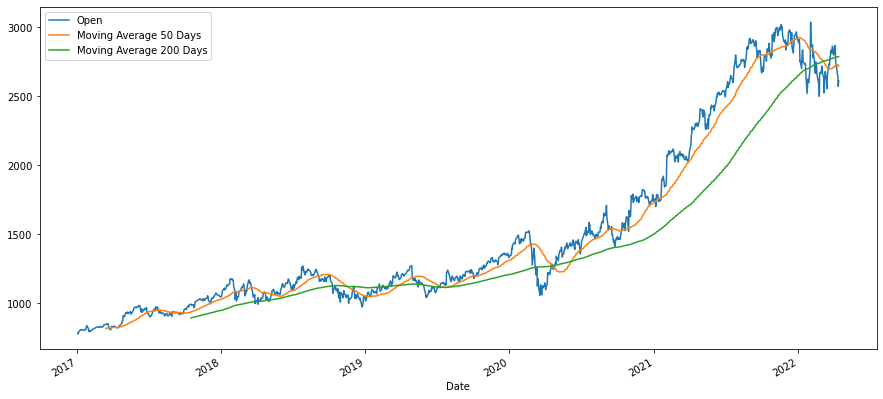

In [46]:
#Exponentially Weighted Moving Average (# days)
goog["Open"].plot(figsize=(15,7))
goog["Moving Average 50"] = goog["Open"].rolling(50).mean()
goog["Moving Average 50"].plot(label="Moving Average 50 Days", linewidth=1.5)
goog["Moving Average 200"] = goog["Open"].rolling(200).mean()
goog["Moving Average 200"].plot(label="Moving Average 200 Days", linewidth=1.5)
plt.legend()
plt.show()

Hmmmm, the graph seems to be lagging behind the actual price too much. Let's try an exponential weighted moving average, which gives more recent dates a higher weight, balanced out with a lower weight for the eariler days.

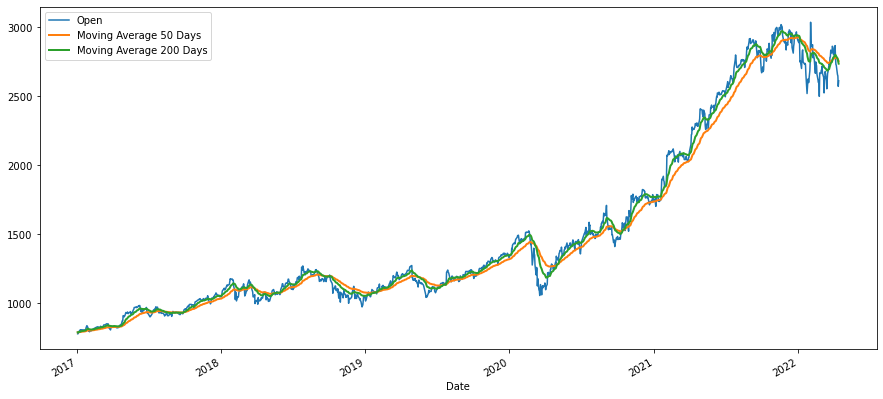

In [47]:
#Evenly Weighted Moving Average (# days)
goog["Open"].plot(figsize=(15,7))
goog["Moving Average 50"] = goog.iloc[:,0].ewm(span=50,adjust=False).mean()
goog["Moving Average 50"].plot(label="Moving Average 50 Days", linewidth=2)
goog["Moving Average 200"] = goog.iloc[:,0].ewm(span=20,adjust=False).mean()
goog["Moving Average 200"].plot(label="Moving Average 200 Days", linewidth=2)
plt.legend()
plt.show()

This looks like a much better representation of medium and long term valuation! Also, you might have noticed that the more days in a moving average, the flatter the data. For example, a 200 day moving average is the average price of the previous 200 days, whereas a 50 day moving average is the average price of the previous 50 days. Larger numbers are less prone to small fluctiations.

<h4>Stock Price Correlation<h/4>

When we are analyzing a series of stocks, one important thing to keep in mind is the relationship between different stock prices. Is there a linear correlation between various stock prices?

To comapre the opening prices for our three companies, we will create a new `DataFrame`, or table, by concatenating the opening price columns of the different companies.

In [29]:
comparison = pd.concat([amzn["Open"],tsla["Open"],goog["Open"]], axis=1)
comparison.columns = ["Amazon Open", "Tesla Open", "Google Open"]

Now, we will make a scatter matrix to compare the relationships between each combination of companies:

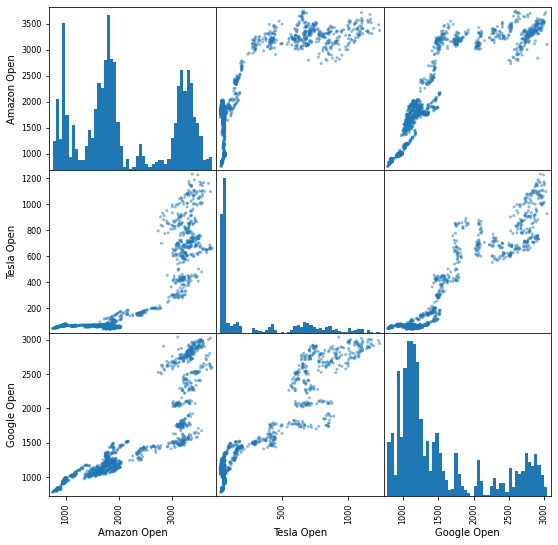

In [30]:
pd.plotting.scatter_matrix(comparison, hist_kwds={'bins':50}, figsize=(9,9))
plt.show()

From this graph, we can see some sort of exponential association between each combination of securities. This is mostly because Tesla's price has grown exponentially in recent years, which you can tell by the shape of the histogram plot's, most notably Tesla's.

<h4>Volatility</h4>

Volatility is very important when comapring stocks, because is it much more difficult to gain back losses (in terms of percentage). For example, a 50% decrease requires a 100% increase to return to the original value.

For each company, let's calculate the daily return for each day:

In [31]:
amzn["daily_return"] = (amzn["Close"] / amzn["Close"].shift(1)) - 1
tsla["daily_return"] = (tsla["Close"] / tsla["Close"].shift(1)) - 1
goog["daily_return"] = (goog["Close"] / goog["Close"].shift(1)) - 1

Now, let's plot a histogram of the distribution of daily returns for one company.

<AxesSubplot:ylabel='Frequency'>

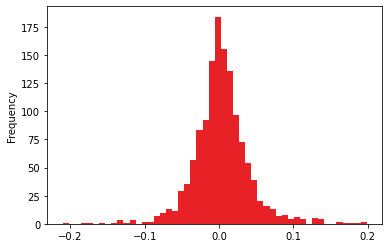

In [32]:
tsla["daily_return"].plot.hist(bins=50, color=tsla_color)

In [33]:
tsla["daily_return"].describe()

count    1330.000000
mean        0.003081
std         0.038331
min        -0.210628
25%        -0.016203
50%         0.001660
75%         0.019815
max         0.198949
Name: daily_return, dtype: float64

From this data, you can see that the security has had 1327 trading days, and averaged a 0.3084 percent gain each day.

That number might sound small (it really isn't), but if a security were to gain 0.3084 percent every trading day in one year (253 days), it would equate to about an 18% gain over an entire year.

In [34]:
#(1 + mean)^253 - 1
mean = tsla["daily_return"].mean()
np.power(1 + mean, 253) - 1

1.1776004060676435

Let's compare all three daily return histograms:

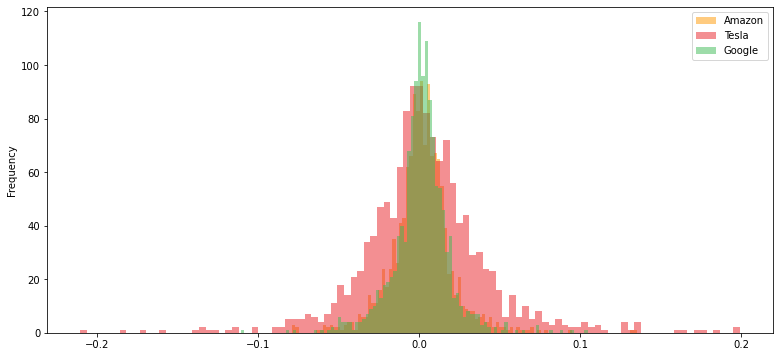

In [35]:
amzn["daily_return"].plot.hist(bins=100, label="Amazon", alpha=0.5, color=amzn_color, figsize=(13,6))
tsla["daily_return"].plot.hist(bins=100, label="Tesla", alpha=0.5, color=tsla_color)
goog["daily_return"].plot.hist(bins=100, label="Google", alpha=0.5, color=goog_color)
plt.legend()
plt.show()

We can tell that Tesla has wider tails that Google and Amazon, which means that it is most likely more volatile. To confirm, let's make a <a href="https://en.wikipedia.org/wiki/Kernel_density_estimation">Kernel density estimation</a> plot, which to standardize the data across the companies, as shown below:

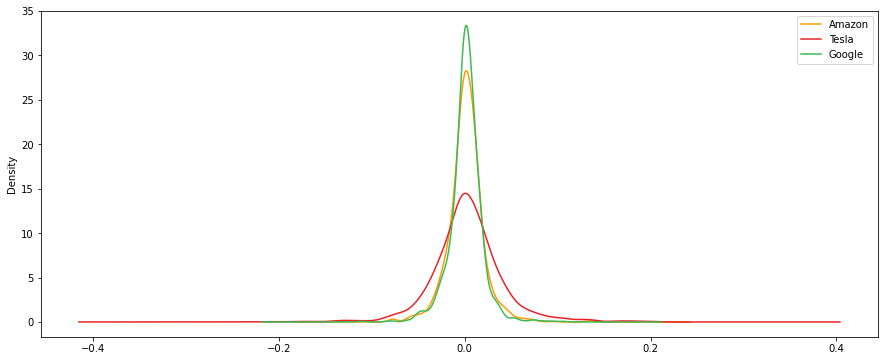

In [36]:
#Kernel Density Estimation
amzn["daily_return"].plot(kind="kde", label="Amazon", color=amzn_color, figsize=(15,6))
tsla["daily_return"].plot(kind="kde", label="Tesla", color=tsla_color)
goog["daily_return"].plot(kind="kde", label="Google", color=goog_color)
plt.legend()
plt.show()

From this graph, we can tell that Google is the least volatile security, Amazon is slightly more volatile, and Tesla is the most volatile.

Let's make some boxplots to compare the price volatilities of each ticker:

<AxesSubplot:>

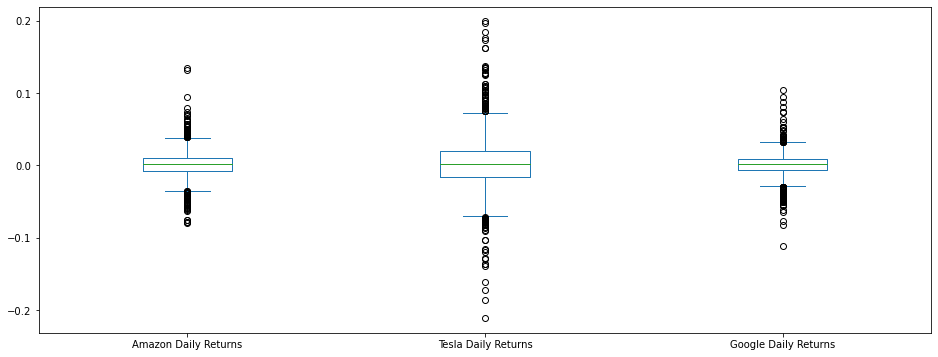

In [37]:
box_df = pd.concat([amzn["daily_return"], tsla["daily_return"], goog["daily_return"]], axis=1)
box_df.columns=["Amazon Daily Returns", "Tesla Daily Returns", "Google Daily Returns"]
box_df.plot(kind="box", figsize=(16,6))

The boxplots confirm the findings from the Kernel density estimation. Now, let's make a scatter matrix to compare the daily returns between each combination of companies:

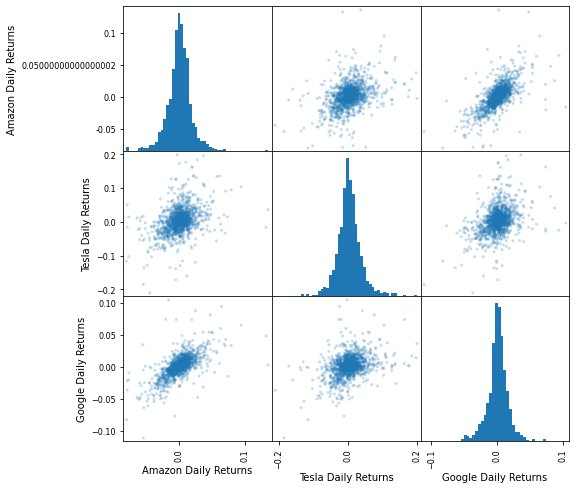

In [38]:
pd.plotting.scatter_matrix(box_df, hist_kwds={"bins":50}, alpha=0.25, figsize=(8,8))
plt.show()

We can see that there is a weak positive correlation between each comapny's daily returns, with a slightly stronger correlation between Google's and Amazon's daily returns.

<h4>Candlestick Graphing</h4>

Day traders use candlestick graphs to track movement in a stock price throughout the day.

<img src="candlestick.png"></img>

If you are interested in learning more about candlesticks, check out this article: https://www.investopedia.com/trading/candlestick-charting-what-is-it/

In [39]:
#%pip install mpl_finance
from mplfinance.original_flavor import candlestick_ohlc
import matplotlib.dates as dates

#%pip install yfinance
import yfinance as yf

tsla_day_prices = yf.download(tickers="TSLA",
                            period="1d",
                            interval="5m",
                            auto_adjust=True)
tsla_day_prices = tsla_day_prices.reset_index()
tsla_day_prices

[*********************100%***********************]  1 of 1 completed


,Datetime,Open,High,Low,Close,Volume
0,2022-04-14 09:30:00-04:00,999.289978,1011.700012,998.030029,1010.570007,2158652
1,2022-04-14 09:35:00-04:00,1010.969971,1012.709900,1000.320007,1001.000000,601219
2,2022-04-14 09:40:00-04:00,1000.989990,1003.567017,998.210022,998.554993,531737
3,2022-04-14 09:45:00-04:00,998.239990,999.679993,992.200012,993.304993,569034
4,2022-04-14 09:50:00-04:00,992.288696,994.280029,990.440002,993.989990,598109
...,...,...,...,...,...,...
74,2022-04-14 15:40:00-04:00,987.159973,990.015015,987.159973,989.705017,150669
75,2022-04-14 15:45:00-04:00,989.640015,991.039978,988.571899,989.330017,216359
76,2022-04-14 15:50:00-04:00,989.140015,989.140015,985.000000,987.107483,427549
77,2022-04-14 15:55:00-04:00,987.000000,988.818604,984.075012,984.960022,652725


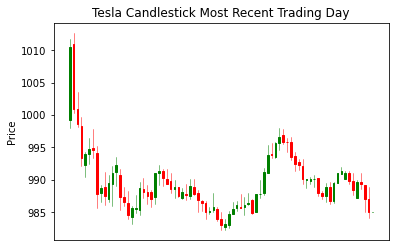

In [40]:
tsla_day_prices["date_ax"] = tsla_day_prices["Datetime"].apply(lambda date: dates.date2num(date))
tsla_tuple = [tuple(vals) for vals in tsla_day_prices[["date_ax", "Open", "High", "Low", "Close"]].values]


fig, ax = plt.subplots()
candlestick_ohlc(ax, tsla_tuple, width=0.0015, colorup="g")
plt.xticks([])
plt.title("Tesla Candlestick Most Recent Trading Day")
plt.ylabel("Price")
plt.show()

From this candlestick graph, we can recognize the price movement of the security for that day. 

Special thanks to the following YouTube videos for providing some of the code that I used in this notebook:
<ol>
    <li><a href>https://www.youtube.com/watch?v=7sFCOunKL_Y</a></li>
    <li><a href>https://www.youtube.com/watch?v=57qAxRV577c</a></li>
</ol>